<a href="https://colab.research.google.com/github/tubes886/sustainable-farming/blob/main/Sustainable_Farming_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Notebook setup

!gdown --id 1DgOZ56YruuUmHRD7hZNJNM39mlbRGApp # sample metadata
!gdown --id 1R4Nv1SY4zn_Z3wnZuJcCHKI6yVPGGgGZ # bacteria counts lognorm

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from sklearn.tree import plot_tree
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV

metadata = pd.read_table('sample_metadata.tsv')
metadata.index = ['farm_%i' % i for i in range(len(metadata))]

bacteria_counts_lognorm = pd.read_csv('bacteria_counts_lognorm.csv', index_col=0)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score, mean_absolute_error

Downloading...
From: https://drive.google.com/uc?id=1DgOZ56YruuUmHRD7hZNJNM39mlbRGApp
To: /content/sample_metadata.tsv
100% 64.3k/64.3k [00:00<00:00, 25.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1R4Nv1SY4zn_Z3wnZuJcCHKI6yVPGGgGZ
To: /content/bacteria_counts_lognorm.csv
7.44MB [00:00, 98.3MB/s]


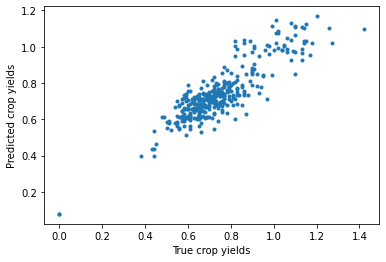

r2_score: 0.778887861265825


In [ ]:
# Building multiple machine learning models to vote on their prediction for a label is called ensemble learning
# Train different models using slightly different sets of features, ask them to vote on best prediction
# Can then either take majority vote (for classification) or average the votes (for regression)
# Ensemble machine learning model built using many decision trees = Random forest- to improve crop-yield-from-bacteria model

# Defining X and y data
X = bacteria_counts_lognorm
y = metadata['crop_yield']


# Splitting data into testing and training
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Initializing model; n_estimators = the number of decision trees in random forest
model = RandomForestRegressor(n_estimators=10)

# Training model with training data
model.fit(X_train, y_train)

# Predicting on test data
preds = model.predict(X_test)

# Plotting predictions against true crop yields of test data
plt.plot(y_test, preds, '.')
plt.xlabel('True crop yields')
plt.ylabel('Predicted crop yields')
plt.show()

# Computing r2_score using r2_score(y_test, preds)
print('r2_score:', r2_score(y_test, preds))

In [ ]:
# Feature-reduced model; if any feature_importance = zero, that feature does not get used in the model
# Thus the number of features used in the model equals the number of non zero feature importance
# See how many features are used in the model

feature_importances = model.feature_importances_
n_possible_features = len(feature_importances)
n_features_used = sum(feature_importances != 0)
print("The random forest model used %i out of a possible %i features" % 
      (n_features_used, n_possible_features))

The random forest model used 500 out of a possible 632 features


In [ ]:
# In feature-reduced models, model is penalized for having more features = model will pick only a few very important features to use
# Computing training and testing R2 values to see if original model was overfitting

# Predict on the training data.
y_pred_train = model.predict(X_train) ## FILL IN ###
training_r2 = r2_score(y_train, y_pred_train) ## FILL IN ###

# Predict on the testing data.
y_pred_test = model.predict(X_test) ## FILL IN ###
# Compare the predictions on the training data against the true crop yields.
testing_r2 = r2_score(y_test, y_pred_test)

print("Training r2: %", training_r2)
print("Testing r2: %", testing_r2)

Training r2: % 0.9617150197876021
Testing r2: % 0.778887861265825


How different values of ```ccp_alpha``` affect the number of features in a model and its accuracy


In [ ]:
ccp_alpha = 0.00002 #@param {type:"slider", min:0.00001, max:0.0001, step:0.00001}
model = RandomForestRegressor(n_estimators=10, ccp_alpha=ccp_alpha)
model.fit(X_train, y_train)
print("Using ccp_alpha=", ccp_alpha)
print("Pruned Model Training R2:", r2_score(y_train,model.predict(X_train)))
print("Pruned Model Testing R2:", r2_score(y_test,model.predict(X_test)))
print("Number of non-zero feature importances in pruned model:", sum(model.feature_importances_!=0))

Using ccp_alpha= 2e-05
Pruned Model Training R2: 0.9265239283594277
Pruned Model Testing R2: 0.7752095956724803
Number of non-zero feature importances in pruned model: 328


In [ ]:
# Building feature-reduced model
# Pruning incentivizes model to use less features 
# Random forest "prunes"/removes branches to decrease the number of features being used, even if sacrificing training accuracy a bit 
# Adding an argument ccp_alpha (ccp stands for cross-complexity pruning) to RandomForestRegressor can specify how much pruning we want to be done  
# A higher value of ccp_alpha means the model will perform more pruning

# Using cross validation to decide best value of ccp_alpha
# Split training set into a training and validation set 
# Model is trained using different values of ccp_alpha and evaluating accuracy using the training set using K different iterations of testing/validation split
# Choose value of ccp_alpha that has best average accuracy for final training output
# K-fold cross validation is good for evaluating a model's accuracy because every sample in the dataset will be part of the training and testing set at some iteration in the k-fold cross validation process

model = RandomForestRegressor(n_estimators=10)

# Instead of specifying ccp_alpha to the RandomForestRegressor class, 
# pass RandomForestRegressor to GridSearchCV model class and indicate ccp_alpha values the model should go through

# Passing model to GridSearchCV and values of ccp_alpha to try
model_cv = GridSearchCV(model, param_grid={'ccp_alpha': [.00001, .00002, .00003, .00004, .00005]})


model_cv.fit(X_train, y_train)
print("Pruned Model Training R2:", r2_score(y_train,model_cv.predict(X_train)))
print("Pruned Model Testing R2:", r2_score(y_test,model_cv.predict(X_test)))
print("Best value of ccp_alpha:", model_cv.best_estimator_.ccp_alpha)
print("Number of non-zero feature importances in best model:", sum( model_cv.best_estimator_.feature_importances_!=0))

Pruned Model Training R2: 0.9118598397453602
Pruned Model Testing R2: 0.7675142668650488
Best value of ccp_alpha: 3e-05
Number of non-zero feature importances in best model: 308
